# Spanish Translation A/B Test

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
%matplotlib inline
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import tree
import graphviz

## Data Loading

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
test = pd.read_csv('/content/gdrive/MyDrive/take_home_challenge/02_Spanish_Translation_A B_Test/test_table.csv')
user = pd.read_csv('/content/gdrive/MyDrive/take_home_challenge/02_Spanish_Translation_A B_Test/user_table.csv')

In [4]:
test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [5]:
user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [ ]:
#Check duplicates
len(test.user_id.unique()) == test.shape[0], len(user.user_id.unique()) == user.shape[0]

(True, True)

In [ ]:
len(test.user_id.unique()),len(user.user_id.unique())

(453321, 452867)

In [ ]:
len([i for i in test.user_id if i not in user.user_id]), len([i for i in user.user_id if i not in test.user_id])

(248137, 247685)

looks like the user_id in each table does not match with each other

## Data Cleaning

In [6]:
data = test.merge(user,on='user_id',how='left')

In [ ]:
for col in data.columns[data.isnull().any()]:
  print(col)
  print('------------')
  print(data[col].value_counts())


ads_channel
------------
Facebook    68425
Google      68180
Yahoo       27435
Bing        13689
Other        4148
Name: ads_channel, dtype: int64
sex
------------
M    264485
F    188382
Name: sex, dtype: int64
age
------------
21.0    27601
22.0    27287
23.0    27064
20.0    27046
24.0    26805
19.0    26714
25.0    26091
18.0    25907
26.0    24975
27.0    23717
28.0    22134
29.0    20712
30.0    19319
31.0    17680
32.0    16109
33.0    14211
34.0    12630
35.0    11236
36.0     9603
37.0     8172
38.0     7214
39.0     5816
40.0     4984
41.0     4129
42.0     3376
43.0     2687
44.0     2155
45.0     1760
46.0     1388
47.0     1057
48.0      860
49.0      637
50.0      494
51.0      358
52.0      267
53.0      229
54.0      130
55.0      109
56.0       58
57.0       51
58.0       30
60.0       21
59.0       14
61.0       11
63.0        6
62.0        5
64.0        2
65.0        2
70.0        1
68.0        1
67.0        1
66.0        1
Name: age, dtype: int64
country
-----------

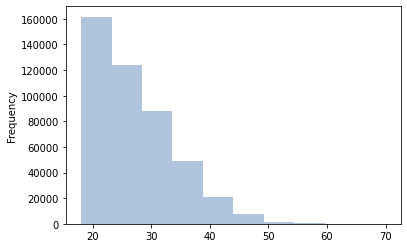

In [ ]:
data['age'].plot.hist(color='lightsteelblue')

In [ ]:
data['age'].mean()

27.130740371897268

In [7]:
for col in data.columns[data.isnull().any()]:
  if col == 'age':
    data[col] = data[col].fillna(data['age'].mean())
  else:
    data[col] = data[col].fillna('N/A')

## Check the conversion rate of each country 

In [8]:
data[['country','conversion']].groupby('country').mean()

,conversion
country,
Argentina,0.013994
Bolivia,0.048634
Chile,0.049704
Colombia,0.051332
Costa Rica,0.053494
Ecuador,0.049072
El Salvador,0.050765
Guatemala,0.049653
Honduras,0.049253


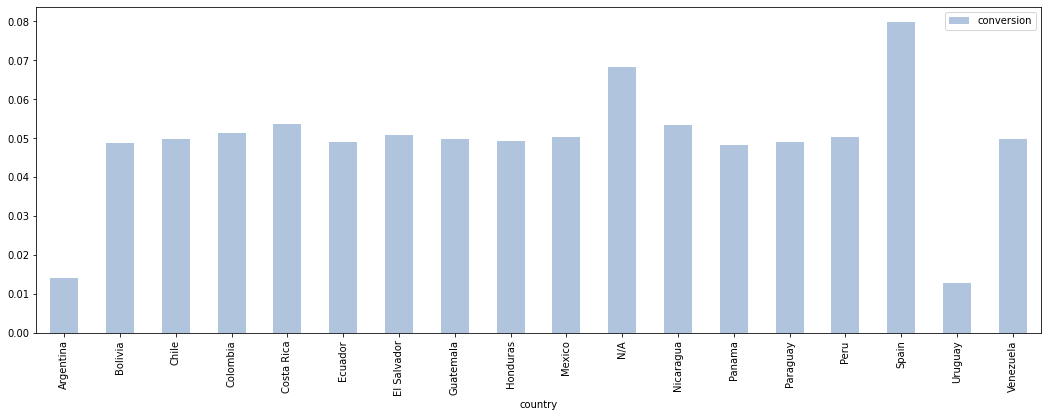

In [9]:
data[['country','conversion']].groupby('country').mean().plot.bar(figsize = (18,6),color='lightsteelblue')

## Some Observations:
1. It is true that conversion rate of Spain is higher than other countries.
2. The conversion rates of Argentina and Uruguay are lower than other countries 

## Check the correctness of A/B test result

In [10]:
group_exp = data[(data['country'] != 'Spain') & (data['test'] == 1)]
group_con = data[(data['country'] != 'Spain') & (data['test'] == 0)]

In [11]:
group_exp['conversion'].mean(),group_con['conversion'].mean()

(0.043424713982118966, 0.04833042316066309)

In [12]:
stats.ttest_ind(group_exp['conversion'].values, group_con['conversion'].values)

Ttest_indResult(statistic=-7.422512095954769, pvalue=1.15144687852198e-13)

(pvalue < 0.05)  It seems that the conversion rate of locally translated group is lower based on the provided data.

## Check the variable distribution

In [ ]:
group_exp[['date','conversion']].groupby('date').mean().reset_index()

,date,conversion
0,2015-11-30,0.043886
1,2015-12-01,0.041387
2,2015-12-02,0.044234
3,2015-12-03,0.043884
4,2015-12-04,0.043491


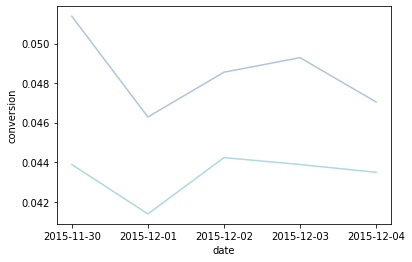

In [13]:
#date
sns.lineplot(x='date',y='conversion',data=group_exp[['date','conversion']].groupby('date').mean().reset_index(),color='lightblue')
sns.lineplot(x='date',y='conversion',data=group_con[['date','conversion']].groupby('date').mean().reset_index(),color='lightsteelblue')

The trend looks roughly similar.

In [14]:
test_data = data[data['country']!='Spain']
test_data

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico
5,540675,2015-12-03,Direct,Mobile,ES,N/A,Android_App,0,1,F,22.0,Venezuela
6,863394,2015-12-04,SEO,Mobile,Other,N/A,Android_App,0,0,M,35.0,Mexico
...,...,...,...,...,...,...,...,...,...,...,...,...
453315,783089,2015-12-02,Ads,Mobile,ES,Bing,Android_App,0,0,F,20.0,Mexico
453316,425010,2015-12-04,SEO,Web,ES,N/A,FireFox,0,0,M,50.0,Mexico
453317,826793,2015-12-01,SEO,Mobile,ES,N/A,Android_App,0,1,F,20.0,Colombia
453319,785224,2015-12-04,SEO,Mobile,ES,N/A,Android_App,0,1,M,21.0,Colombia


Text(0.5, 1.0, 'The conversion rate in 2 groups')

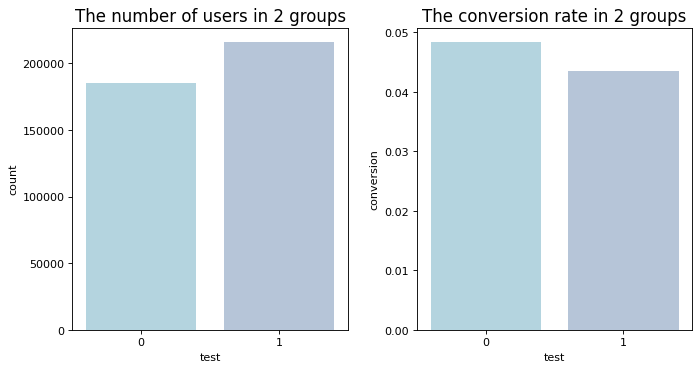

In [15]:
group_conversion = test_data[['test','conversion']].groupby('test').mean().reset_index()

colors = ['lightblue','lightsteelblue']
plt.subplots(figsize=(10,5),dpi=80)
plt.subplots_adjust(wspace=0.25)

plt.subplot(1,2,1)
sns.countplot(x='test',data=test_data,palette=colors)
plt.title('The number of users in 2 groups',fontsize=15)

plt.subplot(1,2,2)
sns.barplot(x='test',y='conversion',data=group_conversion,palette=colors)
plt.title('The conversion rate in 2 groups',fontsize=15)


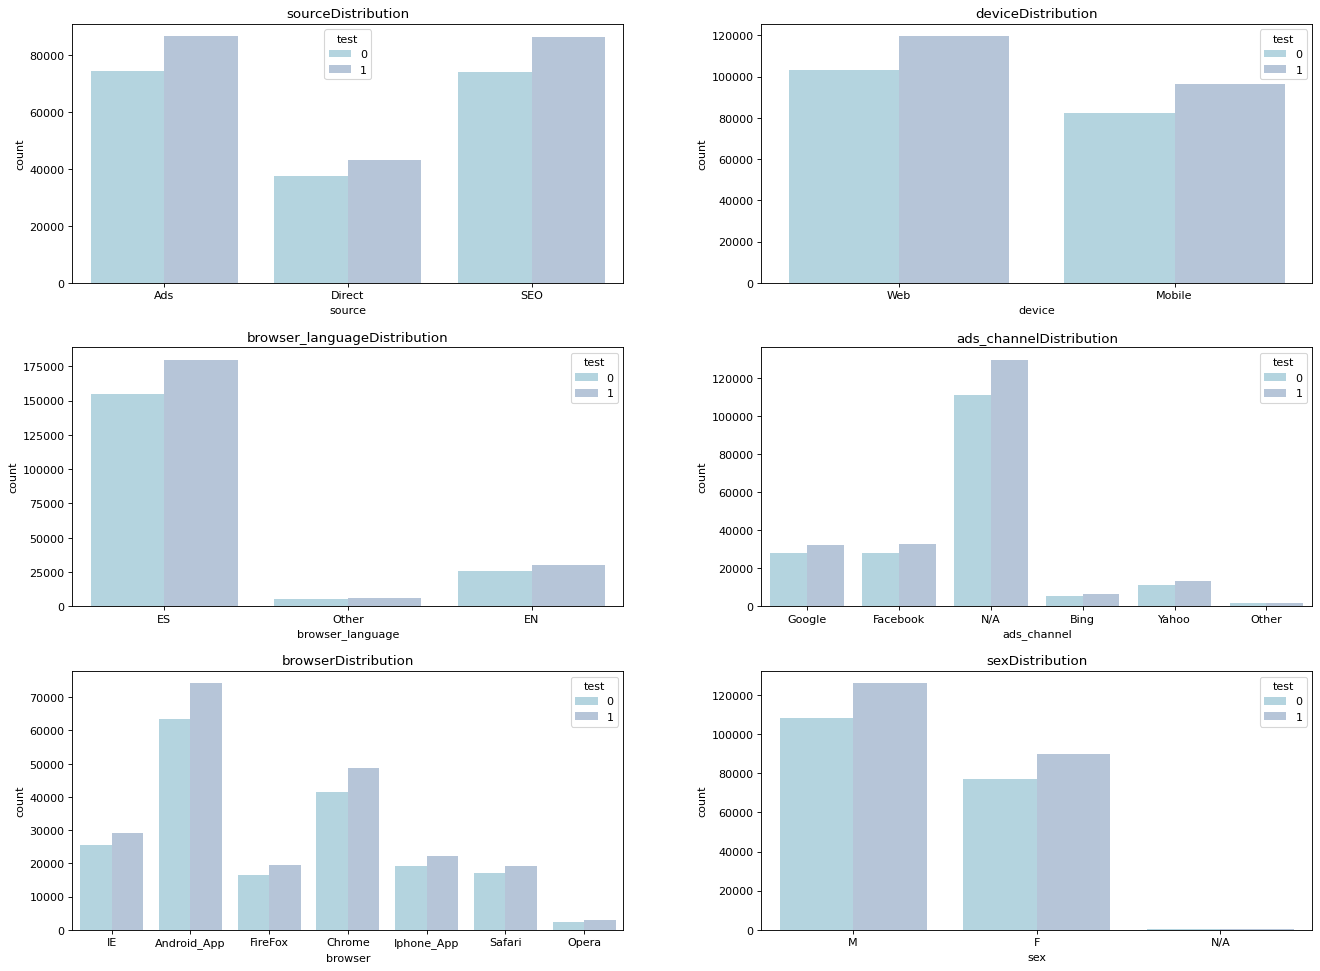

In [16]:
#Check the number of users in different groups divided by different variables
columns = test_data.columns.tolist()[2:7]+test_data.columns.tolist()[9:-2]
plt.subplots(figsize=(20,15),dpi=80)
plt.subplots_adjust(wspace=0.25,hspace=0.25)

i = 1
for col in columns:
  plt.subplot(3,2,i)              
  sns.countplot(x=col,hue='test',data=test_data,palette=colors)
  plt.title(col + 'Distribution')
  i += 1

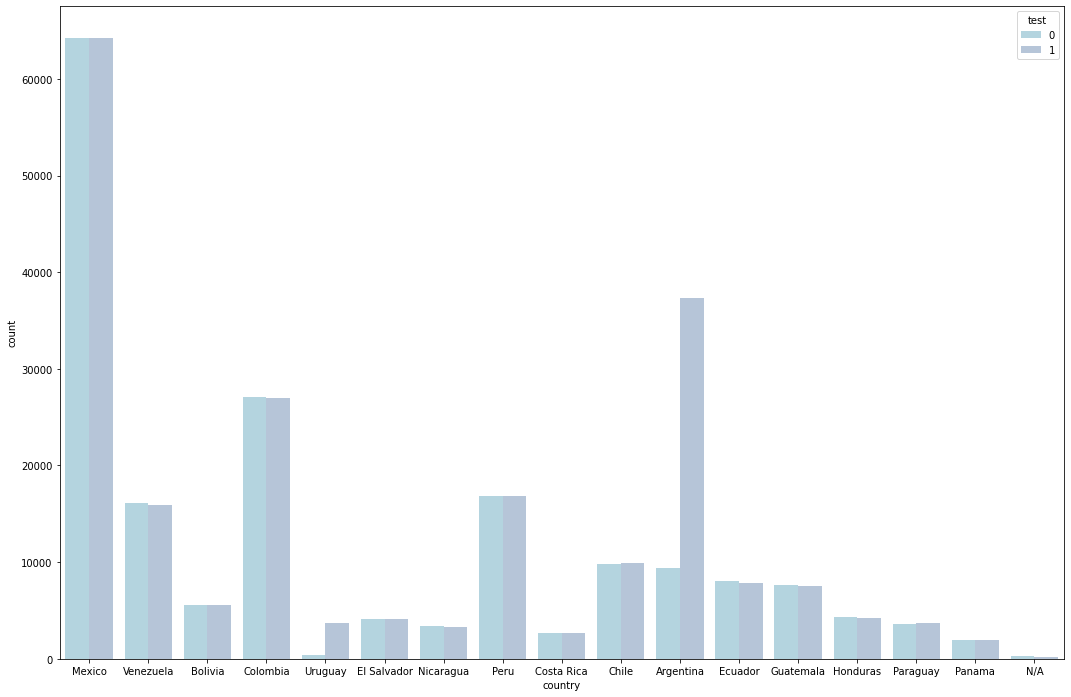

In [ ]:
fig,ax = plt.subplots(figsize=(18,12))
sns.countplot(x='country',hue='test',data=test_data,palette=colors,ax=ax)

The data for Argentina and Uruguay is not balanced.

Text(0.5, 1.0, 'Age Distribution per group')

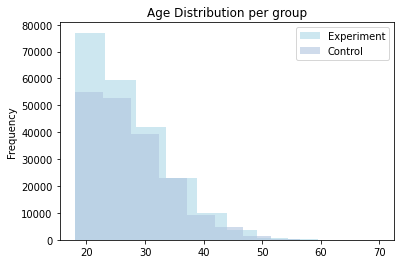

In [ ]:
#Check age
kwargs = dict({'bins':10,'alpha':0.6})
test_data.loc[test_data['test'] == 1].age.plot.hist(color = colors[0],**kwargs,label='Experiment')
test_data.loc[test_data['test'] == 0].age.plot.hist(color = colors[1],**kwargs,label='Control')
plt.legend()
plt.title('Age Distribution per group')

We should investigate on the country variable.

In [ ]:
test_data

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico
5,540675,2015-12-03,Direct,Mobile,ES,N/A,Android_App,0,1,F,22.0,Venezuela
6,863394,2015-12-04,SEO,Mobile,Other,N/A,Android_App,0,0,M,35.0,Mexico
...,...,...,...,...,...,...,...,...,...,...,...,...
453315,783089,2015-12-02,Ads,Mobile,ES,Bing,Android_App,0,0,F,20.0,Mexico
453316,425010,2015-12-04,SEO,Web,ES,N/A,FireFox,0,0,M,50.0,Mexico
453317,826793,2015-12-01,SEO,Mobile,ES,N/A,Android_App,0,1,F,20.0,Colombia
453319,785224,2015-12-04,SEO,Mobile,ES,N/A,Android_App,0,1,M,21.0,Colombia


In [17]:
data_countries = test_data.country.unique().tolist()
data_countries.remove('N/A')
p_value, exp_conversion, con_conversion = [],[],[]
for country in data_countries:
  exp = test_data.loc[(test_data['country']==country)&(test_data['test']==1)].conversion.values
  con = test_data.loc[(test_data['country']==country)&(test_data['test']==0)].conversion.values
  
  exp_conversion.append(exp.mean())
  con_conversion.append(con.mean())
  p_value.append(stats.ttest_ind(exp, con)[1])

country_test = pd.DataFrame({'country':data_countries,'exp_group_conversion':exp_conversion,'con_group_conversion':con_conversion,'p_value':p_value})
country_test

,country,exp_group_conversion,con_group_conversion,p_value
0,Mexico,0.051186,0.049495,0.165547
1,Venezuela,0.048978,0.050344,0.573740
2,Bolivia,0.047901,0.049369,0.718877
3,Colombia,0.050571,0.052089,0.423733
4,Uruguay,0.012907,0.012048,0.882812
5,El Salvador,0.047947,0.053554,0.248251
6,Nicaragua,0.054177,0.052647,0.780351
7,Peru,0.050604,0.049914,0.771950
8,Costa Rica,0.054738,0.052256,0.687863
9,Chile,0.051295,0.048107,0.302871


We cannot reject the hypothesis based on the p-value of individual countries.\
Since the data for Argentina and Uruguay is not balanced, next we should do the test excluding these 2 countries.

In [34]:
balance_data = test_data.loc[~((test_data['country']=='Argentina') | (test_data['country']=='Uruguay'))]

group_exp = balance_data[balance_data['test'] == 1]
group_con = balance_data[balance_data['test'] == 0]

stats.ttest_ind(group_exp['conversion'].values, group_con['conversion'].values)

Ttest_indResult(statistic=0.31810128971456436, pvalue=0.7504082947797941)

It seems that there's no proof that the conversion rate of locally-translated version is lower.

## Algorithm:
Build a Decision Model and check the feature importance.

In [35]:
test_data

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico
5,540675,2015-12-03,Direct,Mobile,ES,N/A,Android_App,0,1,F,22.0,Venezuela
6,863394,2015-12-04,SEO,Mobile,Other,N/A,Android_App,0,0,M,35.0,Mexico
...,...,...,...,...,...,...,...,...,...,...,...,...
453315,783089,2015-12-02,Ads,Mobile,ES,Bing,Android_App,0,0,F,20.0,Mexico
453316,425010,2015-12-04,SEO,Web,ES,N/A,FireFox,0,0,M,50.0,Mexico
453317,826793,2015-12-01,SEO,Mobile,ES,N/A,Android_App,0,1,F,20.0,Colombia
453319,785224,2015-12-04,SEO,Mobile,ES,N/A,Android_App,0,1,M,21.0,Colombia


In [54]:
model_data = test_data[['test','source','device','browser_language','ads_channel','browser','sex','country','age']]
columns = model_data.select_dtypes(include='object').columns.tolist()
Dt_data = pd.get_dummies(model_data, columns=columns)

In [55]:
Dt_data

,test,age,source_Ads,source_Direct,source_SEO,device_Mobile,device_Web,browser_language_EN,browser_language_ES,browser_language_Other,...,country_Guatemala,country_Honduras,country_Mexico,country_N/A,country_Nicaragua,country_Panama,country_Paraguay,country_Peru,country_Uruguay,country_Venezuela
1,1,21.0,1,0,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
3,1,22.0,1,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
4,1,19.0,1,0,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
5,1,22.0,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
6,0,35.0,0,0,1,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453315,0,20.0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
453316,0,50.0,0,0,1,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
453317,1,20.0,0,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
453319,1,21.0,0,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Decision Tree

In [62]:
X = Dt_data.iloc[:,1:]
y = Dt_data.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=0)

In [75]:
dTree = tree.DecisionTreeClassifier(max_depth=5).fit(X_train,y_train)
y_predict = dTree.predict(X_test)

In [76]:
dTree.score(X_train,y_train),dTree.score(X_test,y_test)

(0.5417108065613256, 0.5379675189422526)

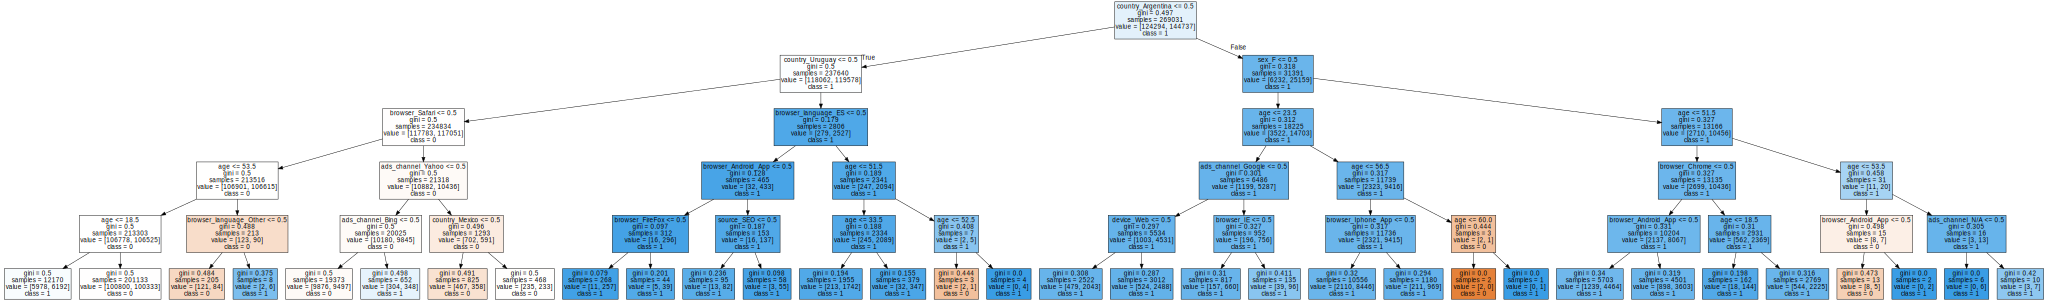

In [81]:
draw = tree.export_graphviz(dTree,out_file=None,feature_names=Dt_data.columns.tolist()[1:],filled=True,class_names=['0','1'])

graph = graphviz.Source(draw,format='png')
graph

In [85]:
from sklearn.tree import export_text
r = export_text(dTree, feature_names=Dt_data.columns.tolist()[1:])
print(r)

|--- country_Argentina <= 0.50
|   |--- country_Uruguay <= 0.50
|   |   |--- browser_Safari <= 0.50
|   |   |   |--- age <= 53.50
|   |   |   |   |--- age <= 18.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- age >  18.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- age >  53.50
|   |   |   |   |--- browser_language_Other <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- browser_language_Other >  0.50
|   |   |   |   |   |--- class: 1
|   |   |--- browser_Safari >  0.50
|   |   |   |--- ads_channel_Yahoo <= 0.50
|   |   |   |   |--- ads_channel_Bing <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- ads_channel_Bing >  0.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- ads_channel_Yahoo >  0.50
|   |   |   |   |--- country_Mexico <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- country_Mexico >  0.50
|   |   |   |   |   |--- class: 0
|   |--- country_Uruguay >  0.50
|   |   |--- browser_language_ES <= 0.50
|   |   |   |--- bro

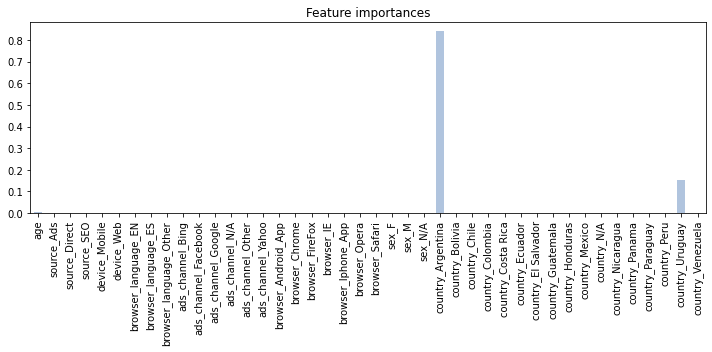

In [88]:
features_names = Dt_data.columns.tolist()[1:]
importances = dTree.feature_importances_
indice = np.argsort(importances)
tree_importances = pd.Series(importances, index=features_names)

fig, ax = plt.subplots(figsize=(10,5))
tree_importances.plot.bar(ax=ax,color=colors[1])
ax.set_title("Feature importances")
fig.tight_layout()

It seems that the factors 'country_Argentina' and 'country_Uruguay' make the group split not random enough.